<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/ML_income_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, roc_curve,
                            confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

In [2]:
# 1. Load Data
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/Dataset/income.csv"
data = pd.read_csv(url)

# 2. Preprocessing Khusus
# Handle missing values di fitur
data['workclass'] = data['workclass'].fillna('Unknown')
data['occupation'] = data['occupation'].fillna('Unknown')
data['native-country'] = data['native-country'].fillna('Unknown')

# 3. Pisahkan Fitur dan Target
X = data.drop(['income', 'fnlwgt', 'education'], axis=1)
y = data['income'].str.strip()  # Pastikan tidak ada whitespace

# 4. Pastikan tidak ada nilai aneh di target
valid_income = ['<=50K', '>50K']
y = y[y.isin(valid_income)]  # Filter hanya nilai yang valid

In [4]:
# Sesuaikan X dengan y yang sudah difilter
X = X.loc[y.index]

# 5. Encode target (<=50K: 0, >50K: 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 6. Pipeline Preprocessing
numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
])

# 7. Model Pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

dtree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=5,
        random_state=42,
        class_weight='balanced'
    ))
])

In [5]:
# 8. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# 9. Training
print("Training model...")
knn_pipeline.fit(X_train, y_train)
dtree_pipeline.fit(X_train, y_train)

Training model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        random_state=42))])


=== Evaluasi k-NN ===
Accuracy: 0.8385
Precision: 0.6848
Recall: 0.6097
F1-Score: 0.6451
ROC AUC: 0.8705


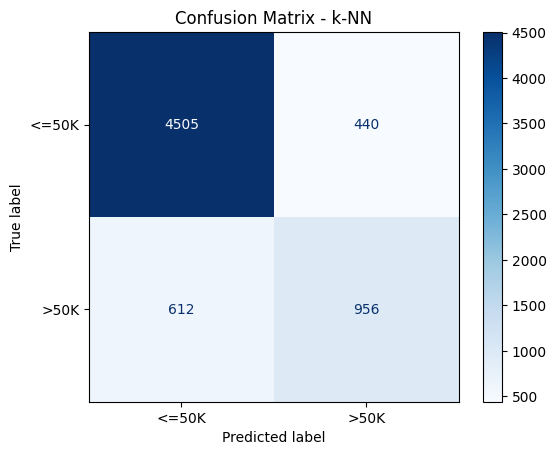


=== Evaluasi Decision Tree ===
Accuracy: 0.7815
Precision: 0.5279
Recall: 0.8756
F1-Score: 0.6587
ROC AUC: 0.8917


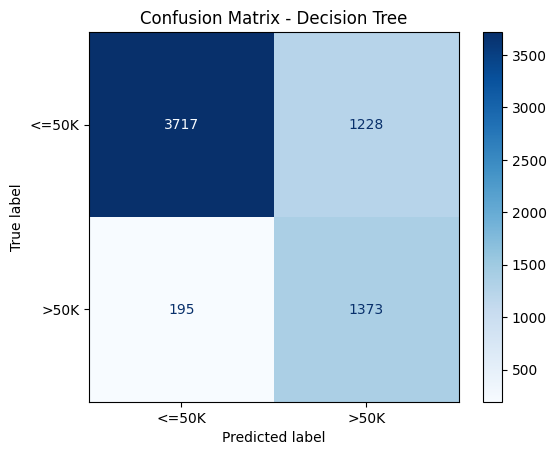

In [6]:
# 10. Evaluasi
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n=== Evaluasi {model_name} ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

evaluate_model(knn_pipeline, X_test, y_test, "k-NN")
evaluate_model(dtree_pipeline, X_test, y_test, "Decision Tree")


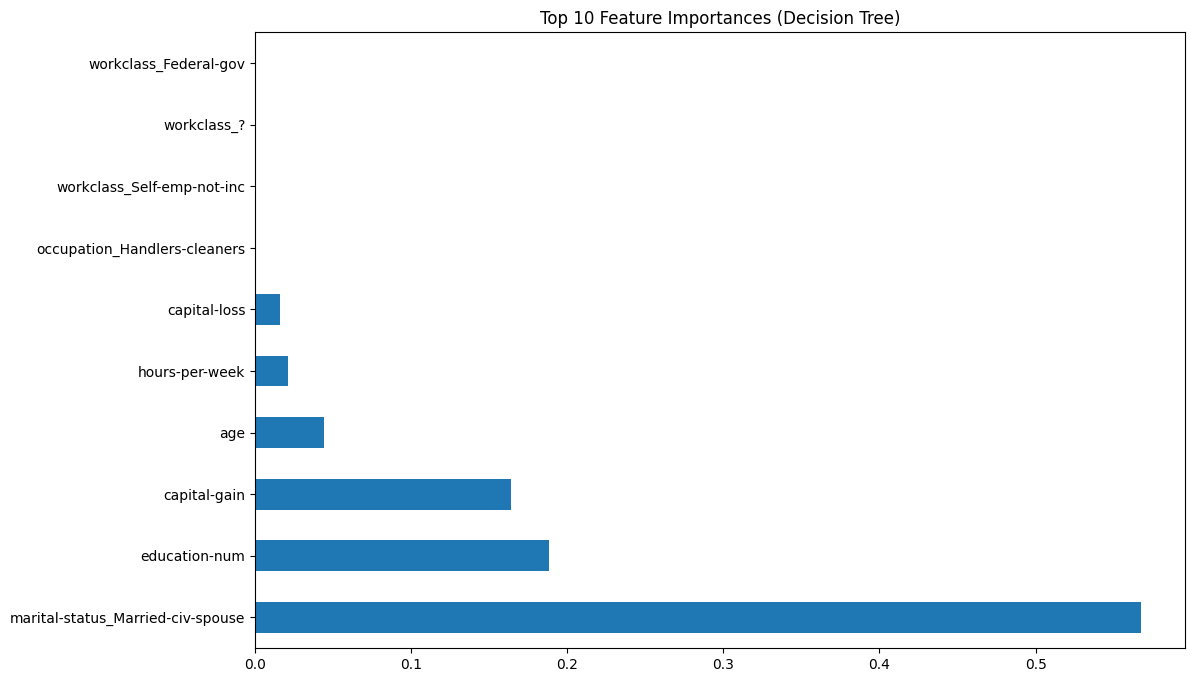

In [7]:
# 11. Feature Importance
dtree = dtree_pipeline.named_steps['classifier']
importances = dtree.feature_importances_

cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

plt.figure(figsize=(12, 8))
pd.Series(importances, index=all_features).nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.show()

# Penjelasan Metrik Evaluasi Model

### 1. **Akurasi (Accuracy)**
Akurasi mengukur persentase prediksi yang benar dari semua prediksi yang dilakukan. Misalnya, jika model memprediksi 4505 benar dan 956 salah, maka akurasi dihitung dengan rumus:

\[
\text{Akurasi} = \frac{4505 + 956}{4505 + 612 + 440 + 956} = 0.8385
\]

Artinya, sekitar 83.85% prediksi model benar.

### 2. **Presisi (Precision)**
Presisi mengukur dari semua prediksi yang mengklasifikasikan seseorang sebagai berpenghasilan >50K, berapa persen yang benar. Rumus presisi adalah:

\[
\text{Presisi} = \frac{956}{956 + 440} = 0.6848
\]

Dengan kata lain, 68.48% dari orang yang diprediksi memiliki penghasilan >50K benar-benar memiliki penghasilan lebih dari itu.

### 3. **Recall (Sensitivitas)**
Recall mengukur dari semua orang yang benar-benar memiliki penghasilan >50K, berapa banyak yang dapat dideteksi oleh model. Recall dihitung dengan rumus:

\[
\text{Recall} = \frac{956}{956 + 612} = 0.6097
\]

Ini berarti bahwa model berhasil mendeteksi sekitar 60.97% orang yang berpenghasilan >50K.

### 4. **F1-Score**
F1-Score adalah rata-rata harmonik antara presisi dan recall. Nilai ini memberikan gambaran umum tentang keseimbangan antara kedua metrik tersebut, yang penting jika Anda ingin menyeimbangkan antara menghindari kesalahan positif dan mendeteksi data yang relevan.

\[
\text{F1-Score} = 2 \times \frac{\text{Presisi} \times \text{Recall}}{\text{Presisi} + \text{Recall}} = 0.6451
\]

### 5. **ROC AUC (Receiver Operating Characteristic - Area Under the Curve)**
ROC AUC mengukur kemampuan model untuk membedakan antara dua kelas (misalnya, ≤50K dan >50K). Nilai ROC AUC yang lebih tinggi menunjukkan bahwa model lebih baik dalam membedakan antara kedua kelas tersebut. Contohnya, untuk model Decision Tree, nilai ROC AUC adalah 0.8917.

---

### **Perbandingan Metrik antara k-NN dan Decision Tree**

| Metrik       | k-NN      | Decision Tree |
|--------------|-----------|---------------|
| **Akurasi**  | 0.8385    | 0.7815        |
| **Presisi**  | 0.6848    | 0.5279        |
| **Recall**   | 0.6097    | 0.8756        |
| **F1-Score** | 0.6451    | 0.6587        |
| **ROC AUC**  | 0.8705    | 0.8917        |

### **Analisis Metrik**
- **Akurasi:** k-NN memiliki akurasi yang lebih tinggi (83.85% dibandingkan 78.15% untuk Decision Tree). Namun, akurasi kurang relevan jika data tidak seimbang, karena dapat lebih bias terhadap kelas mayoritas (≤50K).
  
- **Presisi:** k-NN lebih unggul dalam presisi (68.48% dibandingkan 52.79% pada Decision Tree). Ini berarti k-NN lebih akurat dalam memprediksi orang yang berpenghasilan >50K, dengan lebih sedikit kesalahan positif (False Positive).
  
- **Recall:** Decision Tree jauh lebih baik dalam recall (87.56% dibandingkan 60.97% pada k-NN). Model ini lebih efektif dalam mendeteksi orang yang benar-benar berpenghasilan >50K, yang berarti lebih sedikit orang kaya yang terlewat (False Negative).

- **F1-Score:** Decision Tree sedikit lebih unggul (0.6587 dibandingkan 0.6451 pada k-NN). F1-Score memberikan gambaran tentang keseimbangan antara presisi dan recall, dan Decision Tree sedikit lebih baik dalam hal ini.

- **ROC AUC:** Decision Tree juga lebih baik dalam ROC AUC (0.8917 dibandingkan 0.8705 pada k-NN), menunjukkan bahwa model ini lebih baik dalam membedakan antara kedua kelas tersebut.

### **Kesimpulan**
Pemilihan model terbaik bergantung pada tujuan dan kebutuhan spesifik:
- Jika fokus utama adalah mengurangi kesalahan dalam memprediksi income tinggi (minimalkan False Positive), maka k-NN adalah pilihan yang lebih baik karena memiliki presisi yang lebih tinggi.
- Jika prioritas utama adalah mendeteksi income tinggi sebanyak mungkin (minimalkan False Negative), maka Decision Tree lebih disarankan, karena memiliki recall yang lebih tinggi.
- Jika keseimbangan antara presisi dan recall, serta kemampuan umum dalam membedakan kelas, penting, maka Decision Tree adalah pilihan yang lebih baik karena nilai F1-Score dan ROC AUC yang lebih tinggi.
